# **Driving Drowsiness Detection** - Validation

----------
*Master's in Automation and Robotics - ETSII (UPM)*\
**Subject:** Computer Vision\
**Course:** 2023-24\
**Student Name (ID):**
- Ivonne Quishpe (23146)
- Gustavo Maldonado (23102)
- Jorge Guijarro (23075)
- Micaela Cabrera (23023)
- Josep Mª Barberá (17048)

**Date:** December, 6

------------
This Notebook uses the drowsiness detection system for images. To validate the correct functioning and generalization of the model, a test set has been created with more than 100 images with 8 types of expressions, e.g., left eye open, right eye closed and mouth open. These possible states have been encoded with three bits where 1 represents closed and 0 open and the most significant bit refers to the left eye and the least to the mouth. The test set is loaded from Google Drive itself as this Notebook has been implemented in Google Colab.

Libraries

In [ ]:
try:
  if DATA_IS_LOADED:
    pass
except:
    !pip install mediapipe
    !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
DATA_IS_LOADED = True
from google.colab.patches import cv2_imshow
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from google.colab import drive
import glob
drive.mount('/content/drive/', force_remount=True)

# For Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## **Feature Extraction**

In [3]:
def get_face_points(detection_result):
  # Save the landmark coordinates for  the eyes
  right_landmarks = [33, 160, 157, 133, 153, 144]
  right_eye_points = []
  for landmark in right_landmarks:
    right_eye_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])

  left_landmarks = [362, 385, 388, 263, 373, 380]
  left_eye_points = []
  for landmark in left_landmarks:
    left_eye_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])

  # Save the landmark coordinates for  the mouth
  mouth_landmarks = [78, 81, 13, 311, 308, 402, 14, 178]
  mouth_points = []
  for landmark in mouth_landmarks:
    mouth_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])
  return right_eye_points, left_eye_points, mouth_points

In [4]:
def get_EARs(l_p, r_p):

  p2_p6 = np.linalg.norm(l_p[1]-l_p[5])
  p3_p5 = np.linalg.norm(l_p[2]-l_p[4])
  p1_p4 = np.linalg.norm(l_p[0]-l_p[3])
  left_EAR = (p2_p6 + p3_p5)/(2*p1_p4)

  p2_p6 = np.linalg.norm(r_p[1]-r_p[5])
  p3_p5 = np.linalg.norm(r_p[2]-r_p[4])
  p1_p4 = np.linalg.norm(r_p[0]-r_p[3])
  right_EAR = (p2_p6 + p3_p5)/(2*p1_p4)

  return left_EAR, right_EAR

In [5]:
def get_MAR(m_p):

  p2_p8 = np.linalg.norm(m_p[1]-m_p[7])
  p3_p7= np.linalg.norm(m_p[2]-m_p[6])
  p4_p6 = np.linalg.norm(m_p[3]-m_p[5])
  p1_p5 = np.linalg.norm(m_p[0]-m_p[4])
  MAR = (p2_p8 + p3_p7 + p4_p6)/(2*p1_p5)

  return MAR

In [6]:
def face_mesh(image_path):
    base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)

    # Load the input image.
    my_image = cv2.imread(image_path)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=my_image)

    # Detect face landmarks from the input image.

    detection_result = detector.detect(image)

    right_eye_points, left_eye_points, mouth_points = get_face_points(detection_result)
    left_EAR, right_EAR = get_EARs(np.array(left_eye_points), np.array(right_eye_points))
    MAR = get_MAR(np.array(mouth_points))

    return left_EAR, right_EAR, MAR

In [7]:
def from_data_to_number(l_EAR, r_EAR, MAR):
  if (l_EAR < 0.15):
    first = "1"
  else:
    first = "0"

  if (r_EAR < 0.15):
    second = "1"
  else:
    second = "0"

  if (MAR < 0.17):
    third = "1"
  else:
    third = "0"

  return first + second + third

In [9]:
path = r"/content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos*"
folders = glob.glob(path)
# print(folders)
y_pred = []
y_true = []

for folder in folders:
  # print(f"opening folder {folder}")
  sub_folders = glob.glob(folder + "/*")
  for sub_folder in sub_folders:
    # print(f"opening subfolder {sub_folder}")
    files = glob.glob(sub_folder + "/*.jpg")
    i = 4
    j = 7
    if (files == []):
      files = glob.glob(sub_folder + "/*.jpeg")
      i = 5
      j = 8
      if (files == []):
        files = glob.glob(sub_folder + "/*.JPEG")
        i = 5
        j = 8
        if (files == []):
          print("there are not photos in this folder...")
    for myfile in files:
      try:
        l_EAR, r_EAR, MAR = face_mesh(myfile)
        prediction = from_data_to_number(l_EAR, r_EAR, MAR)
        y_pred.append(prediction)
        actual = myfile[-j:-i]
        y_true.append(actual)
      except:
        print(f"no output for file: {myfile}")

no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Chema/Frente_Lejos/110.jpg
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Lado/110.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Lado/111.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Lado/000.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Frente/110.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Frente/111.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Lejos_Frente/001.JPEG
no output for file: /content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos_Micaela/Cerca_Lado/100.

109


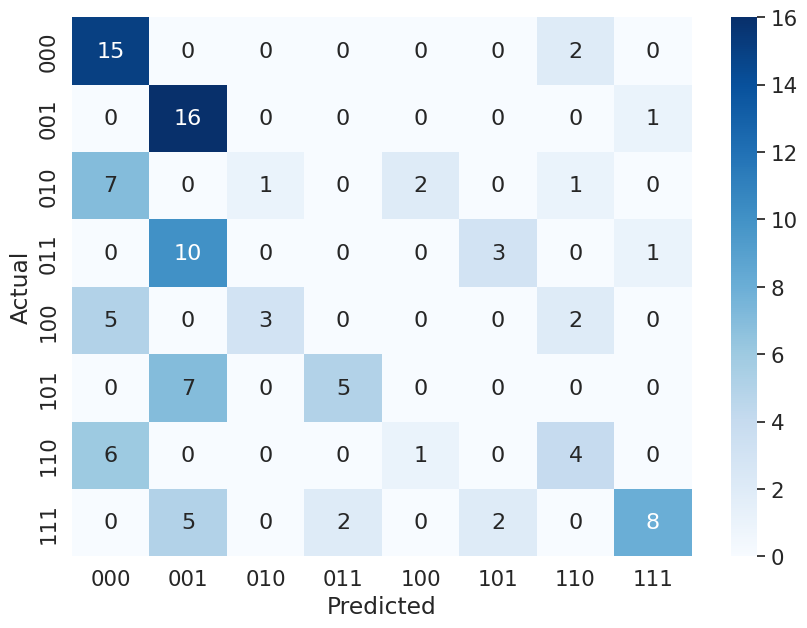

In [10]:
print(len(y_true))
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')


In [11]:
# success rate
b = df_cm.values

print(f"Succes rate = {np.trace(b)/len(y_true)*100:.3}%")


Succes rate = 40.4%
